In [0]:
if False:
    !git clone https://github.com/lukoshkin/ml2020.git
    !mv ml2020/project/src/* .
    !mv ml2020/project/multivar_data.zip ..
    !rm ml2020 -rf

Persistence Landscapes in Data Augmentation
---

***Initialization cells***

In [0]:
import copy
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

![ -z "$(pip list | grep 'sktime')" ] && pip install sktime
from sktime.utils.load_data import load_from_arff_to_dataframe
from nets import *

# for Maks' imports
![ -z "$(pip list | grep 'giotto-tda')" ] && pip install giotto-tda
from tda_tools import *

In [0]:
mode = 'cnn'  # better not to change to rnn, since cnn is superior
              # mode affects only autoencoder choice and its dataloader
    
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

# Choose which data to upload: univariate or multivariate
multivariate = False
dataset_name = 'Coffee'

# multivariate = True
# dataset_name = 'HandMovementDirection'

In [0]:
def get_batches(X_train, y_train=None, batch_size=3, mode='rnn'):
    if mode == 'rnn':
        ids = torch.randperm(X_train.size(1))
        if y_train is None:
            for bx in X_train[:,ids].chunk(batch_size, 1):
                yield bx
        else:
            for bx,by in zip(
                X_train[:,ids].chunk(batch_size, 1),
                y_train[ids].chunk(batch_size)):
                yield bx,by
    elif mode == 'cnn':
        ids = torch.randperm(len(X_train))
        if y_train is None:
            for bx in X_train[ids].chunk(batch_size):
                yield bx
        else:
            for bx,by in zip(
                X_train[ids].chunk(batch_size),
                y_train[ids].chunk(batch_size)):
                yield bx,by
    else:
        raise TypeError("arg type must be 'cnn' or 'rnn'")

# Preprocessing Part

## Univariate Data

### Data Loading

In [1108]:
out = None
if not multivariate:
    # Install and import of https://pypi.org/project/uea-ucr-datasets/
    ![ -z "$(pip list | grep 'Cython')" ] && pip install Cython
    ![ -z "$(pip list | grep 'uea-ucr-datasets')" ] && pip install uea-ucr-datasets

    data_dir = Path('../data')
    data_dir.mkdir(exist_ok=True)
    %env UEA_UCR_DATA_DIR={data_dir}
    import uea_ucr_datasets as ucr_ds


    # Download univariate dataset (preprocessed by sktime)
    url = ('http://www.timeseriesclassification.com/'
           'Downloads/Archives/Univariate2018_ts.zip')
    if not (data_dir/'archive.zip').exists():
        !wget -O {data_dir}/archive.zip {url}


    # Extract files from the archive
    num_files = !ls {data_dir} | wc -l
    print(data_dir)
    if int(num_files[0]) < 129:
        print('not all datasets are present')
        !unzip -qn {data_dir}/archive.zip -d {data_dir}
        !mv -n {data_dir}/Univariate_ts/* {data_dir}
        !rm {data_dir}/Univariate_ts -rf


    # Data Description
    print('Printing the description of the selected dataset')
    !head -8 {data_dir}/{dataset_name}/{'%s_TRAIN.ts' % dataset_name}

    ds_train= ucr_ds.Dataset(dataset_name, train=True)
    ds_test = ucr_ds.Dataset(dataset_name, train=False)
    print('\nData content (partial display):')
    print('-------------------------------')
    print('time-series labels')
    print(ds_train.data_y)
    print('\ntable with sequences')
    out = ds_train.data_x.head()
    emb_size = 1
out

env: UEA_UCR_DATA_DIR=../data
../data
Printing the description of the selected dataset
#"FoodFood spectrographs are used in chemometrics to classify food types, a task that has obvious applications in food safety and quality assurance. The coffee data set is a two class problem to distinguish between Robusta and Aribica coffee beans. Further information can be found in the original paper Briandet et al. Discrimination of Arabica and Robusta in Instant Coffee by Fourier Transform Infrared Spectroscopy and Chemometrics J. Agricultural and Food Chemistry, 44 (1), 1996. The data was first used in the time series classification literature in Bagnall et al. Transformation Based Ensembles for Time Series Classification, SDM 2012.
@problemName Coffee
@timeStamps false
@missing false
@univariate true
@equalLength true
@seriesLength 286
@classLabel true 0 1

Data content (partial display):
-------------------------------
time-series labels
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'

,dim_0
0,0 -0.518419 1 -0.485884 2 -0.50500...
1,0 -0.548462 1 -0.533681 2 -0.51472...
2,0 -0.472634 1 -0.415546 2 -0.35992...
3,0 -0.509521 1 -0.484218 2 -0.47795...
4,0 -0.563427 1 -0.533896 2 -0.54382...


---

### Data unpacking

Since the dataset is small, we can load the whole data and slice it into chunks

In [0]:
if not multivariate:
    X = []
    for v in ds_train.data_x.values: X.append(v[0])
    seq_length = len(v[0])
    
    if mode == 'rnn':
        X_train = torch.Tensor(X).permute(1,0)[...,None]
        y_train = torch.LongTensor(pd.factorize(ds_train.data_y)[0])
    else:
        X_train = torch.Tensor(X)[:,None]
        y_train = torch.LongTensor(pd.factorize(ds_train.data_y)[0])
    X_train, y_train = X_train.to(device), y_train.to(device)
    
    n_classes = len(torch.unique(y_train))

    X = []
    for v in ds_test.data_x.values: X.append(v[0])
    if mode == 'rnn':
        X_test = torch.Tensor(X).permute(1,0)[...,None]
        y_test = torch.LongTensor(pd.factorize(ds_test.data_y)[0])
    else:
        X_test = torch.Tensor(X)[:,None]
        y_test = torch.LongTensor(pd.factorize(ds_test.data_y)[0])
    X_test, y_test = X_test.to(device), y_test.to(device)

## Multivariate Data

Loading all datasets is a pretty heavy procedure.  
So, we download just 2-3 datasets to a local directory and then hook up the right one by its name

### Data unpacking

In [0]:
out = None
if multivariate:
    !unzip -qn ../multivar_data.zip -d ..

    folder = Path('../multivar_time_series')
    X_train_raw, y_train_raw = load_from_arff_to_dataframe(
        folder/dataset_name/f'{dataset_name}_TRAIN.arff')
    X_test_raw, y_test_raw = load_from_arff_to_dataframe(
        folder/dataset_name/f'{dataset_name}_TEST.arff')

    print(f'\nShape of the training dataset: {X_train_raw.shape}')
    emb_size = X_train_raw.shape[1]
    out = X_train_raw.head()
out

In [0]:
if multivariate:
    X = []
    for v in X_train_raw.values:
        X_k = []
        for i in range(emb_size):
            X_k.append(v[i])
        X.append(X_k)
        
    seq_length = len(v[0])
    if mode == 'rnn':
        X_train = torch.Tensor(X).permute(2,0,1)
        y_train = torch.LongTensor(pd.factorize(y_train_raw)[0])
    else:
        X_train = torch.Tensor(X)
        y_train = torch.LongTensor(pd.factorize(y_train_raw)[0])
    X_train, y_train = X_train.to(device), y_train.to(device)
    
    n_classes = len(torch.unique(y_train))

    X = []
    for v in X_test_raw.values:
        X_k = []
        for i in range(emb_size):
            X_k.append(v[i])
        X.append(X_k)
        
    if mode == 'rnn':
        X_test = torch.Tensor(X).permute(2,0,1)
        y_test = torch.LongTensor(pd.factorize(y_test_raw)[0])
    else:
        X_test = torch.Tensor(X)
        y_test = torch.LongTensor(pd.factorize(y_test_raw)[0])
    X_test, y_test = X_test.to(device), y_test.to(device)

## Reducing Dataset

In [1112]:
# if you choose more balanced ids, then
# the the load on the balancing step
# in the intra/extra-polation procedure will be mitigated
# Definitely use it if you are going to exclude
# the balancing step from the augmentation part

more_balanced_choice = True

if more_balanced_choice:
    cnts = y_train.bincount()
    inv_cnts = 1./cnts.float()
    inv_cnts /= inv_cnts.sum()
    
    probs = torch.empty(len(y_train))
    for i, weight in enumerate(inv_cnts):
        probs[y_train == i] = weight
else:
    probs = torch.ones(len(y_train))

# select randomly `share` of all samples from the dataset
share = .3

red_ids = torch.multinomial(probs, int(share*len(y_train)))
X_red = X_train[red_ids]
y_red = y_train[red_ids]
print('# of samples in the dataset you are working with is', len(y_red))

# of samples in the dataset you are working with is 8


## Extracting persistence landscapes

In [0]:
# Maks' cell

# With greed search for the best embedding dimension and time delay
# TIME CONSMUING PROCEDURE
if False:
    X_for_landscapes = X_red.transpose(2,1).cpu()
    y_for_landscapes = y_red.cpu()

    n_layers = 1
    n_steps = 100
    max_time_delay = 10 #maximum time delay for the search
    max_dim = 10 #maximum embedding dimension for the search

    kNN_scores = np.zeros((max_dim - 2,max_time_delay - 2))
    for time_delay in range(2, max_time_delay):
        for dim in range(2, max_dim):
            point_clouds = Takens_Embedding_torch(X_for_landscapes, d=dim, delay=time_delay)
            diagrams, diagrams_np, VR_persistence = get_diagrams_torch(point_clouds)
            landscapes, max_scale = get_landscapes_torch(diagrams, n_layers, n_steps)
            pairwise_distances = landscapes_distances(landscapes, max_scale)
            matching_matrix = y_for_landscapes.numpy()[:, np.newaxis] == y_for_landscapes.numpy()[np.newaxis, :]
            kNN_scores[dim - 2, time_delay - 2] = get_kNN_score_torch(pairwise_distances, matching_matrix=matching_matrix)
            #print("({}, {}, {})".format(dim, time_delay, kNN_scores[dim - 2, time_delay - 2]), end=' ')

    embedding_dim_optimal, time_delay_optimal = np.unravel_index(np.argmax(kNN_scores, axis=None), kNN_scores.shape)
    embedding_dim_optimal += 2
    time_delay_optimal += 2
    print("Optimal embedding dimension: {}\nOptimal time delay: {}".format(embedding_dim_optimal, time_delay_optimal))
            
    fig = plt.figure(figsize = (10,5))
    y, x = np.mgrid[slice(2, max_dim, 1.0),slice(2, max_time_delay, 1.0)]
    plt.pcolormesh(x, y, (kNN_scores>0.95) * kNN_scores)
    plt.colorbar()
    plt.xlabel("Time delay")
    plt.ylabel("Embedding dimension")
    plt.title(dataset_name + " dataset. Embedding parameters with highst kNN score")
    plt.savefig(dataset_name + ' parameters.jpg')
    plt.show()

In [1114]:
# Maks' cell
# The same but without greed search

# Tunable hyperparameters
n_layers = 1    # this value seems fine and easy, better don't change it
n_steps = 100   
embedding_dim = 2 # use here either precomputed values, or found in the previos cell 
time_delay = 2    # use here either precomputed values, or found in the previos cell 

# Extracting train landscapes
X_for_landscapes = X_red.transpose(2,1).cpu()
y_for_landscapes = y_red.cpu()

point_clouds = Takens_Embedding_torch(X_for_landscapes, d=embedding_dim, delay=time_delay)
diagrams, diagrams_np, VR_persistence = get_diagrams_torch(point_clouds)
landscapes, max_scale = get_landscapes_torch(diagrams, n_layers, n_steps)

pairwise_distances = landscapes_distances(landscapes, max_scale)
matching_matrix = y_for_landscapes.numpy()[:, np.newaxis] == y_for_landscapes.numpy()[np.newaxis, :]
kNN_score = get_kNN_score_torch(pairwise_distances, matching_matrix=matching_matrix)

print("Point_clouds shape:", point_clouds.size())
print("Diagrams shape:", diagrams.size())
print("Landscapes shape:", landscapes.size())
print("kNN score:", kNN_score)

land_shape = tuple(landscapes.shape[1:])
landscapes_train = landscapes.to(device)

Point_clouds shape: torch.Size([8, 284, 2])
Diagrams shape: torch.Size([8, 2, 327, 2])
Landscapes shape: torch.Size([8, 2, 1, 100])
kNN score: 0.8125


In [0]:
# Maks' cell

X_for_landscapes = X_test.transpose(2,1).cpu()
y_for_landscapes = y_test.cpu()

point_clouds = Takens_Embedding_torch(X_for_landscapes, d=embedding_dim, delay=time_delay)
diagrams, diagrams_np, VR_persistence = get_diagrams_torch(point_clouds)
landscapes, max_scale = get_landscapes_torch(diagrams, n_layers, n_steps)

pairwise_distances = landscapes_distances(landscapes, max_scale)
matching_matrix = y_for_landscapes.numpy()[:, np.newaxis] == y_for_landscapes.numpy()[np.newaxis, :]
kNN_score = get_kNN_score_torch(pairwise_distances, matching_matrix=matching_matrix)

landscapes_test = landscapes.to(device)

# Network Training Procedures

Here you need to define all hyperparameters to achieve sth worthwhile  
For different datasets, they may take different values

In [0]:
# common variable names
best_weights = None
best_score = [float('inf')]
train_history, test_history = [], []

Useful statistics when bulding networks (to choose appropriate hyperparameters)

In [1117]:
print(emb_size)
print(seq_length)
print(land_shape)
print(X_red.shape)

1
286
(2, 1, 100)
torch.Size([8, 1, 286])


## Auto-encoder's train function

In [0]:
# Autoencoder tunable hyperparameters:
code_size = 100            # compression level
channels = [32, 64, 64]        # number of neurons in hidden layers 
kernel_size = 46
# last two are valid for 'cnn' only

# Optimizer tunable hyperparameters:
lr = 1e-4
step = 2
gamma = .999

args_for_AE = (code_size, channels, kernel_size, lr, step, gamma)

# Here you can choose the loss function
MSE = nn.MSELoss()
MAE = lambda X,Y: (X-Y).abs().mean()
criterion_ae = MAE

def reset_AE_trainables(
    code_size, channels, kernel_size, lr, step, gamma, mode):
    if mode == 'rnn':
        ae = RNNSeqAE(emb_size, code_size, seq_length).to(device)
        mode = 'cnn'
    else:
        ae = ConvSeqAE(
            emb_size, code_size, seq_length,
            channels, kernel_size).to(device)

    opt_ae = optim.Adam(ae.parameters(), lr)
    sch_ae = optim.lr_scheduler.StepLR(opt_ae, step, gamma)
    return ae, opt_ae, sch_ae

# Globally defined variables of the function 'train_*'
ae, opt_ae, sch_ae = reset_AE_trainables(*args_for_AE, mode)

# training procedure
def train_ae(X_train, num_epochs, mode, verbose=True):
    pbar = tqdm(range(num_epochs), 'ae training')
    for epoch in pbar:
        train_loss = []
        for bx in get_batches(X_train, mode=mode):
            opt_ae.zero_grad()
            bx_rec = ae(bx)
            loss = criterion_ae(bx_rec, bx)
            loss.backward()
            train_loss.append(loss.item())
            opt_ae.step()
        sch_ae.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion_ae(ae(X_test), X_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(ae.state_dict())

## Weak classifier's train function

In [0]:
# Classifier tunable hyperparameters:
channels = [6]        # number of neurons in hidden layers 
kernel_size = 3

# Optimizer tunable hyperparameters:
lr = 1e-2
step = 2
gamma = .999

args_for_CLF = (channels, kernel_size, lr, step, gamma)
def reset_CLF_trainables(channels, kernel_size, lr, step, gamma):
    clf = SeqClassifier(
        emb_size, n_classes,
        channels, kernel_size).to(device)
    opt_clf = optim.Adam(clf.parameters(), lr)
    sch_clf = optim.lr_scheduler.StepLR(opt_clf, step, gamma)
    return clf, opt_clf, sch_clf

# Globally defined variables of the function 'train_*'
clf, opt_clf, sch_clf = reset_CLF_trainables(*args_for_CLF)
criterion_clf = nn.CrossEntropyLoss()

# training procedure
def train_clf(X_train, y_train, num_epochs, mode, verbose=True):
    pbar = tqdm(range(num_epochs), 'clf training')
    for epoch in pbar:
        train_loss = []
        for bx,by in get_batches(X_train, y_train, mode=mode):
            opt_clf.zero_grad()
            y_pred = clf(bx)
            loss = criterion_clf(y_pred, by)
            loss.backward()
            train_loss.append(loss.item())
            opt_clf.step()
        sch_clf.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion_clf(clf(X_test), y_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(clf.state_dict())

## Landscape Inverse's train function

In [0]:
# Landscape Inverse tunable hyperparameters
channels = [8, 32, 32, 64]
kernel_size = 46

# Optimizer tunable hyperparameters
lr = 5e-4
step = 2
gamma = .999

args_for_PLI = (channels, kernel_size, lr, step, gamma)
# Choose the loss function here
MSE = nn.MSELoss()
MAE = lambda X,Y: (X-Y).abs().mean()
criterion_pli = MAE

def reset_PLI_trainables(channels, kernel_size, lr, step, gamma):
    pli = LandscapeInverse(
        emb_size, land_shape,
        seq_length, channels, kernel_size).to(device)
    opt_pli = optim.Adam(pli.parameters(), lr)
    sch_pli = optim.lr_scheduler.StepLR(opt_pli, step, gamma)
    return pli, opt_pli, sch_pli

# Globally defined variables of the function 'train_*'
pli, opt_pli, sch_pli = reset_PLI_trainables(*args_for_PLI)

# training procedure
def train_pli(landscapes_train, num_epochs, mode, verbose=True):
    train_ids = torch.arange(len(landscapes_train))
    pbar = tqdm(range(num_epochs), 'pli training')
    for epoch in pbar:
        train_loss = []
        for bx,ids in get_batches(landscapes_train, train_ids, mode=mode):
            opt_pli.zero_grad()
            bx_rec = pli(bx)
            loss = criterion_pli(bx_rec, X_train[ids])
            loss.backward()
            train_loss.append(loss.item())
            opt_pli.step()
        sch_pli.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion_pli(pli(landscapes_test), X_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(pli.state_dict())

## SAE with persistence landscapes' train function

In [0]:
# PLSAE Tunable parameters
channels = [8, 32, 32, 64]
kernel_size = 46

# Optimizer tunable parameters
lr = 5e-4
step = 2
gamma = .999

args_for_SLAE = (channels, kernel_size, lr, step, gamma)

# Choose loss function here
MSE = nn.MSELoss()
MAE = lambda X,Y: (X-Y).abs().mean()
criterion_slae = MAE

def reset_SLAE_trainables(channels, kernel_size, lr, step, gamma):
    slae = TDASAE(emb_size, code_size,
                  seq_length, land_shape, channels, kernel_size).to(device)
    opt_slae = optim.Adam(slae.parameters(), lr)
    sch_slae = optim.lr_scheduler.StepLR(opt_slae, step, gamma)
    return slae, opt_slae, sch_slae

# Globally defined variables of the function 'train_*'
slae, opt_slae, sch_slae = reset_SLAE_trainables(*args_for_SLAE)

# training procedure
def train_slae(X_train, num_epochs, mode, verbose=True):
    train_ids = torch.arange(len(X_train))
    pbar = tqdm(range(num_epochs), 'slae training')
    for epoch in pbar:
        train_loss = []
        for bx,ids in get_batches(X_train, train_ids, mode=mode):
            opt_slae.zero_grad()
            bx_rec = slae(bx, landscapes_train[ids])
            loss = criterion_slae(bx_rec, bx)
            loss.backward()
            train_loss.append(loss.item())
            opt_slae.step()
        sch_slae.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion_slae(slae(X_test, landscapes_test), X_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(slae.state_dict())

## Other tools

In [0]:
def clear_buffers(best_score, list1, list2):
    best_score[0] = float('inf')
    list1.clear(); list2.clear()

In [0]:
def oversampling(
    X, y, augments, k=3, sign=-1,
    lambda_lims=(.3, .7), replacement=False):
    """
    Chooses randomly (num:)`augments[i]` objects from class `i`.
    To every selected object chooses one from its `k` nearests in the class,
    and makes interpolation or extrapolation between them
    
    Args:
    ----
    X   array of shape (batch_size, code_length);
        to apply to persistence landscape, you must 
        reshape it first
        
    replacement    if replacement is False, then (num:)`augments[i]` samples
                   are drawn without replacement. However, when `augments[i]`
                   is less than the size of class `i` replacement is set
                   to `True` for that class regardless of  what argument
                   you provided
    
    sign = -1 -> intrapolation
    sign = +1 -> extrapolation
    
    Interpolation/extrapolation coefficient is randomly chosen
    from the interval `lambda_lims`
    """
    new_X, new_y = [], []
    for lbl, m in enumerate(augments):
        if m == 0: continue
        X_lbl = X[y==lbl]
        n = len(X_lbl)
        
        if m > n: replacement = True
        m_ids = torch.multinomial(
            torch.ones(n), m, replacement)
        mX_lbl = X_lbl[m_ids]
            
        if k > n:
            print('Consider taking a different `k`.\n'
                  'The chosen one may be too big '
                  'for the current dataset')
            print(f'k: {k}\t', f"class #{lbl}'s size: {n}")
            k = min(k, n)
            
        dist_matrix = torch.norm(mX_lbl[:,None]-X_lbl, dim=2)
        dist_matrix[torch.arange(m), m_ids] = float('inf')
        
        k_nearest = (-dist_matrix).topk(k, dim=1)[1]
        k_ids = torch.multinomial(torch.ones(k_nearest.shape), 1)
        mk_ids = k_nearest[torch.arange(m), k_ids.squeeze()]
        
        lambda_ = X.new(m).uniform_(*lambda_lims)[:, None]
        new_X.append((lambda_*sign*(mX_lbl-X_lbl[mk_ids])+mX_lbl))
        new_y.append(y.new_full((m,), lbl))
        
    return torch.cat(new_X), torch.cat(new_y)

# Results Reproduction of DeVries and etc 

## Training autoencoder

In [0]:
best_weights = clear_buffers(best_score, train_history, test_history)
ae, opt_ae, sch_ae = reset_AE_trainables(*args_for_AE, mode)

In [1125]:
train_ae(X_red, 500, mode, verbose=False)

best score: 0.06944864988327026


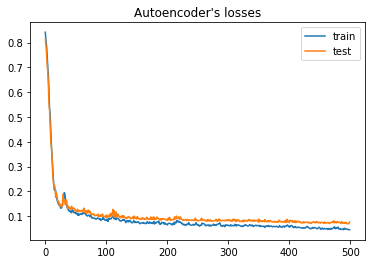

In [1126]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
plt.title("Autoencoder's losses")
print('best score:', best_score[0])
plt.legend();

In [1127]:
# Load best weights
if best_weights:
    ae.load_state_dict(best_weights)
    
# And check the reconstruction
perm_ids = torch.randperm(X_test.size(1))
ae(X_red[:,perm_ids]).squeeze(), X_red[:,perm_ids].squeeze()

(tensor([[-0.4929, -0.5055, -0.5357,  ..., -1.8755, -1.8683, -1.8194],
         [-0.4735, -0.4859, -0.5139,  ..., -1.9317, -1.9213, -1.8768],
         [-0.4926, -0.5052, -0.5353,  ..., -1.8753, -1.8682, -1.8192],
         ...,
         [-0.4719, -0.4843, -0.5123,  ..., -1.9101, -1.9012, -1.8570],
         [-0.4958, -0.5084, -0.5392,  ..., -1.8515, -1.8429, -1.7934],
         [-0.4673, -0.4795, -0.5072,  ..., -1.9268, -1.9149, -1.8708]],
        device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([[-0.5197, -0.4779, -0.4927,  ..., -1.8664, -1.8679, -1.8686],
         [-0.6185, -0.5852, -0.6320,  ..., -1.8666, -1.8682, -1.8699],
         [-0.5918, -0.5710, -0.5900,  ..., -1.8737, -1.8753, -1.8771],
         ...,
         [-0.4964, -0.4657, -0.4158,  ..., -1.9043, -1.9059, -1.9068],
         [-0.5598, -0.5152, -0.5049,  ..., -1.8048, -1.8058, -1.8073],
         [-0.4726, -0.4155, -0.3599,  ..., -1.9891, -1.9907, -1.9923]],
        device='cuda:0'))

## Training classifier on reduced dataset

In [0]:
best_weights = clear_buffers(best_score, train_history, test_history)
clf, opt_clf, sch_clf = reset_CLF_trainables(*args_for_CLF)

In [1129]:
train_clf(X_red, y_red, 500, mode, verbose=False)

best score: 0.35549411177635193


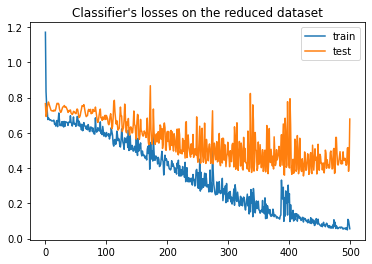

In [1130]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
plt.title("Classifier's losses on the reduced dataset")
print('best score:', best_score[0])
plt.legend();

In [0]:
# Load best weights
if best_weights:
    clf.load_state_dict(best_weights)

In [1132]:
y_pred = clf.predict(X_test)
print('accuracy =', accuracy_score(y_test.cpu(), y_pred))
y_test, y_pred

accuracy = 0.6428571428571429


(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1], device='cuda:0'),
 tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]))

## Applying transformations to extracted code

In [1133]:
code = ae.enc(X_red).detach()
X_augmented, y_augmented = [], []

# Tunable hyperparameters
k = 3
M = 4  # chose M: <!! each class will grow by M in "equal augm." !!>
noise_aug = False
sigma = .05

# Balance the number of class representators
cnts = y_red.bincount()
augments = (cnts.max().item() - cnts).tolist()
if any(augments):
    new_code, new_y = oversampling(code, y_red, augments, k)
    new_X = ae.dec(new_code).detach()
    X_augmented.append(new_X)
    y_augmented.append(new_y)

# Equal augmentation
augments = [M] * len(cnts)
for sign in [-1, +1]:
    new_code, new_y = oversampling(code, y_red, augments, k, sign)
    new_X = ae.dec(new_code).detach()
    X_augmented.append(new_X)
    y_augmented.append(new_y)

if noise_aug:
    new_code = code + sigma*torch.randn_like(code)
    X_augmented.append(ae.dec(new_code).detach())
    y_augmented.append(y_red)

X_augmented, y_augmented = map(torch.cat, (X_augmented, y_augmented))
X_augmented = torch.cat((X_red, X_augmented))
y_augmented = torch.cat((y_red, y_augmented))
print('# of samples in augmented dataset:', len(y_augmented))

# of samples in augmented dataset: 26


## Training classifier on augmented dataset (DeVries)

In [0]:
best_weights = clear_buffers(best_score, train_history, test_history)
clf, opt_clf, sch_clf = reset_CLF_trainables(*args_for_CLF)

In [1135]:
train_clf(X_augmented, y_augmented, 1000, mode, False)

best score: 0.6386915445327759


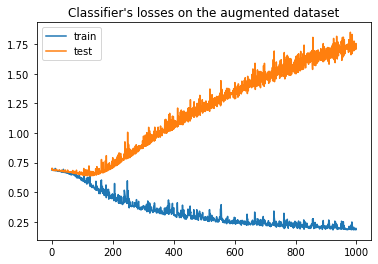

In [1136]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
plt.title("Classifier's losses on the augmented dataset")
print('best score:', best_score[0])
plt.legend();

In [0]:
# Load best weights
if best_weights:
    clf.load_state_dict(best_weights)

In [1138]:
y_pred = clf.predict(X_test)
print('accuracy =', accuracy_score(y_test.cpu(), y_pred))
y_test, y_pred

accuracy = 0.6428571428571429


(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1], device='cuda:0'),
 tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
         1, 0, 1, 1]))

# Augmentation with Persistence Landscapes

## Scheme 1

### Training Landscape Inverse

In [0]:
best_weights = clear_buffers(best_score, train_history, test_history)
pli, opt_pli, sch_pli = reset_PLI_trainables(*args_for_PLI)

In [1140]:
train_pli(landscapes_train, 1000, mode, verbose=False)

best score: 0.09859349578619003


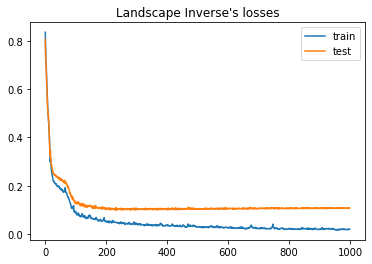

In [1141]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
plt.title("Landscape Inverse's losses")
print('best score:', best_score[0])
plt.legend();

In [0]:
# Load best weights
if best_weights:
    pli.load_state_dict(best_weights)

###  Applying transformations to persistence landscapes

In [1143]:
code = landscapes_train.flatten(1)
X_augmented, y_augmented = [], []

# Tunable hyperparameters
k = 3
M = 4  # chose M: <!! each class will grow by M in "equal augm." !!>
noise_aug = False
sigma  # noise std

# Balance the number of class representators
cnts = y_red.bincount()
augments = (cnts.max().item() - cnts).tolist()
if any(augments):
    new_code, new_y = oversampling(code, y_red, augments, k)
    new_X = pli(new_code.view(-1, *land_shape)).detach()
    X_augmented.append(new_X)
    y_augmented.append(new_y)

# Equal augmentation
augments = [M] * len(cnts)
for sign in [-1, +1]:
    new_code, new_y = oversampling(code, y_red, augments, k, sign)
    new_X = pli(new_code.view(-1, *land_shape)).detach()
    X_augmented.append(new_X)
    y_augmented.append(new_y)

if noise_aug:
    new_code = code + sigma*torch.randn_like(code)
    X_augmented.append(pli(new_code.view(-1, *land_shape)).detach())
    y_augmented.append(y_red)

X_augmented, y_augmented = map(torch.cat, (X_augmented, y_augmented))
X_augmented = torch.cat((X_red, X_augmented))
y_augmented = torch.cat((y_red, y_augmented))
print('# of samples in augmented dataset:', len(y_augmented))

# of samples in augmented dataset: 26


### Training classifier on augmented dataset (Landscape Inverse)

In [0]:
best_weights = clear_buffers(best_score, train_history, test_history)
clf, opt_clf, sch_clf = reset_CLF_trainables(*args_for_CLF)

In [1145]:
train_clf(X_augmented, y_augmented, 1200, mode, False)

best score: 0.29944634437561035


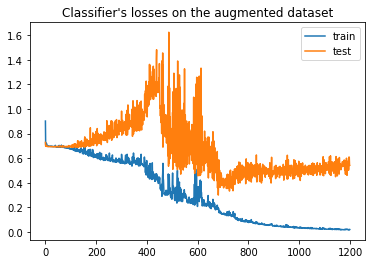

In [1146]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
plt.title("Classifier's losses on the augmented dataset")
print('best score:', best_score[0])
plt.legend();

In [0]:
# Load best weights
if best_weights:
    clf.load_state_dict(best_weights)

In [1148]:
y_pred = clf.predict(X_test) 
print('accuracy =', accuracy_score(y_test.cpu(), y_pred))
y_test, y_pred

accuracy = 0.8571428571428571


(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
         1, 1, 1, 1]))

## Scheme 2

### Training SAE with code/persistence landscapes concatenation

In [0]:
best_weights = clear_buffers(best_score, train_history, test_history)
slae, opt_slae, sch_slae = reset_SLAE_trainables(*args_for_SLAE)

In [1150]:
train_slae(X_red, 1000, mode, verbose=False)

best score: 0.11051333695650101


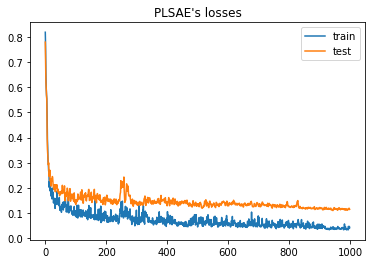

In [1151]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
print('best score:', best_score[0])
plt.title("PLSAE's losses")
plt.legend();

In [0]:
# Load best weights
if best_weights:
    pli.load_state_dict(best_weights)

###  Applying transformations to stacked code and landscape

In [1153]:
code = slae.enc(X_red).detach()
split_sizes = [code.size(1), np.prod(land_shape)]
stacked_code = torch.cat([code, landscapes_train.flatten(1)], 1)

X_augmented, y_augmented = [], []

# Tunable hyperparameters
k = 3
M = 4  # chose M: <!! each class will grow by M in "equal augm." !!>
noise_aug = False

# Balance the number of class representatives
cnts = y_red.bincount()
augments = (cnts.max().item() - cnts).tolist()
if any(augments):
    new_code, new_y = oversampling(stacked_code, y_red, augments, k)
    new_code, new_landscapes = new_code.split(split_sizes, 1)
    new_X = slae.dec(new_code, new_landscapes.view(-1,*land_shape)).detach()
    X_augmented.append(new_X)
    y_augmented.append(new_y)

# Equal augmentation
augments = [M] * len(cnts)
for sign in [-1, +1]:
    new_code, new_y = oversampling(stacked_code, y_red, augments, k, sign)
    new_code, new_landscapes = new_code.split(split_sizes, 1)
    new_X = slae.dec(new_code, new_landscapes.view(-1,*land_shape)).detach()
    X_augmented.append(new_X)
    y_augmented.append(new_y)

if noise_aug:
    new_code = code + sigma*torch.randn_like(code)
    new_landscapes = (landscapes_train 
                      + sigma*torch.randn_like(landscapes_train))
    X_augmented.append(
        slae.dec(new_code, new_landscapes.view(-1,*land_shape)).detach())
    y_augmented.append(y_red)

X_augmented, y_augmented = map(torch.cat, (X_augmented, y_augmented))
X_augmented = torch.cat((X_red, X_augmented))
y_augmented = torch.cat((y_red, y_augmented))
print('# of samples in augmented dataset:', len(y_augmented))

# of samples in augmented dataset: 26


### Training classifier on augmented dataset (SAE + PL)

In [0]:
best_weights = clear_buffers(best_score, train_history, test_history)
clf, opt_clf, sch_clf = reset_CLF_trainables(*args_for_CLF)

In [1155]:
train_clf(X_augmented, y_augmented, 1200, mode, False)

best score: 0.015170642174780369


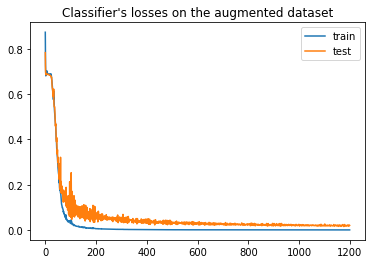

In [1156]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='test')
print('best score:', best_score[0])
plt.title("Classifier's losses on the augmented dataset")
plt.legend();

In [0]:
# Load best weights
if best_weights:
    clf.load_state_dict(best_weights)

In [1158]:
y_pred = clf.predict(X_test) 
print('accuracy =', accuracy_score(y_test.cpu(), y_pred))
y_test, y_pred

accuracy = 1.0


(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]))

---